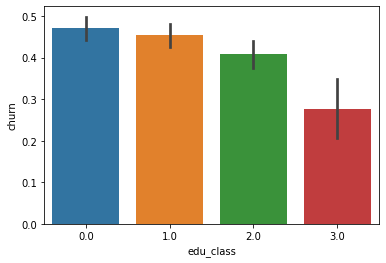

In [2]:
import pandas as pd
import numpy as np
churn = pd.read_csv('telecom_churn.csv')  # 读取已经整理好的数据
churn.head()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.barplot(x='edu_class', y='churn',data=churn)
plt.show()

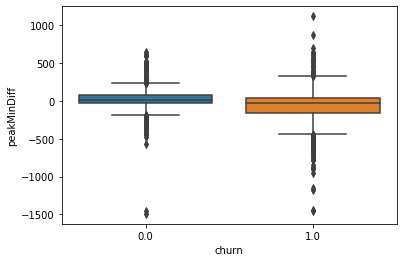

In [3]:
sns.boxplot(x='churn', y='peakMinDiff', hue=None, data=churn)
plt.show()

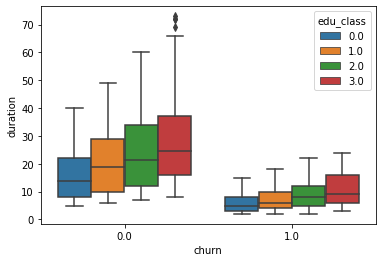

In [4]:
sns.boxplot(x='churn', y='duration', hue='edu_class', data=churn)
plt.show()

In [7]:
corrmatrix = churn.corr(method='spearman')  # spearman相关系数矩阵，可选pearson相关系数，目前仅支持这两种,函数自动排除category类型
corrmatrix_new=corrmatrix[np.abs(corrmatrix) > 0.5]
churn['duration_bins'] = pd.qcut(churn.duration,5)  #  将duration字段切分为数量（大致）相等的5段
churn['churn'].astype('int64').groupby(churn['duration_bins']).agg(['count', 'mean'])
bins = [0, 4, 8, 12, 22, 73]
churn['duration_bins'] = pd.cut(churn['duration'], bins, labels=False)
churn['churn'].astype('int64').groupby(churn['duration_bins']).agg(['mean', 'count'])

,mean,count
duration_bins,,
0,1.000000,525
1,0.607433,861
2,0.464229,629
3,0.262228,736
4,0.001404,712


In [8]:
import sklearn.feature_selection as feature_selection

churn['gender'] = churn['gender'].astype('int')
churn['edu_class'] = churn['edu_class'].astype('int')
churn['feton'] = churn['feton'].astype('int')
feature_selection.chi2(churn[['gender', 'edu_class', 'feton', 'prom', 
                              'posPlanChange','duration_bins', 'curPlan', 'call_10086']], churn['churn'])#选取部分字段进行卡方检验
#根据结果显示，'prom'、'posPlanChange'、'curPlan'字段可以考虑排除

(array([5.52612343e+01, 1.43446961e+01, 1.19205185e+02, 1.11235701e+00,
        2.98137046e-03, 1.25114016e+03, 1.77204831e+00, 5.59152494e+01]),
 array([1.05529433e-013, 1.52207878e-004, 9.44377274e-028, 2.91570161e-001,
        9.56455603e-001, 4.69144344e-274, 1.83128787e-001, 7.56633888e-014]))

In [9]:
model_data = churn[['subscriberID','churn','gender','edu_class','feton','duration_bins','call_10086','AGE']]#第二可选方案
model_data.head()

,subscriberID,churn,gender,edu_class,feton,duration_bins,call_10086,AGE
0,19164958.0,1.0,0,2,0,3,0.0,20.0
1,39244924.0,1.0,1,0,0,1,1.0,20.0
2,39578413.0,1.0,0,1,0,0,1.0,11.0
3,40992265.0,1.0,0,0,0,2,1.0,43.0
4,43061957.0,1.0,1,0,0,3,0.0,60.0


In [10]:
import sklearn.model_selection as cross_validation

target = model_data['churn']  # 选取目标变量
data=model_data.ix[:, 'gender':]  # 选取自变量

train_data, test_data, train_target, test_target = cross_validation.train_test_split(data,target, test_size=0.4, train_size=0.6 ,random_state=12345) # 划分训练集和测试集

D:\Anaconda\anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
D:\Anaconda\anaconda\lib\site-packages\pandas\core\indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


## 使用决策树进行建模

In [11]:
import sklearn.tree as tree

clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_split=5) # 当前支持计算信息增益和GINI
clf.fit(train_data, train_target)  #  使用训练数据建模

# 查看模型预测结果
train_est = clf.predict(train_data)  #  用模型预测训练集的结果
train_est_p=clf.predict_proba(train_data)[:,1]  #用模型预测训练集的概率
test_est=clf.predict(test_data)  #  用模型预测测试集的结果
test_est_p=clf.predict_proba(test_data)[:,1]  #  用模型预测测试集的概率
pd.DataFrame({'test_target':test_target,'test_est':test_est,'test_est_p':test_est_p}).T # 查看测试集预测结果与真实结果对比


,469,1636,1521,2844,2667,1811,2449,3403,314,95,...,357,567,2095,2417,2901,1181,1297,2852,973,1586
test_target,1.0,0.0,0.0,1.0,1.000000,1.0,0.000000,1.000000,0.000000,1.0,...,1.00,0.000000,1.0,1.0,0.0,1.000000,0.0,1.0,0.000000,1.0
test_est,1.0,0.0,1.0,1.0,1.000000,1.0,0.000000,1.000000,0.000000,1.0,...,1.00,0.000000,1.0,1.0,0.0,1.000000,0.0,1.0,0.000000,1.0
test_est_p,0.7,0.0,0.7,1.0,0.736842,1.0,0.289474,0.736842,0.367347,1.0,...,0.75,0.323077,1.0,1.0,0.0,0.741379,0.0,1.0,0.323077,0.9


### 模型评估

In [12]:
import sklearn.metrics as metrics

print(metrics.confusion_matrix(test_target, test_est,labels=[0,1]))  # 混淆矩阵
print(metrics.classification_report(test_target, test_est))  # 计算评估指标
print(pd.DataFrame(list(zip(data.columns, clf.feature_importances_))))  # 变量重要性指标


[[669 112]
 [144 461]]
              precision    recall  f1-score   support

         0.0       0.82      0.86      0.84       781
         1.0       0.80      0.76      0.78       605

    accuracy                           0.82      1386
   macro avg       0.81      0.81      0.81      1386
weighted avg       0.81      0.82      0.81      1386

               0         1
0         gender  0.069254
1      edu_class  0.074757
2          feton  0.059113
3  duration_bins  0.672283
4     call_10086  0.021396
5            AGE  0.103199


### 查看预测值的分布情况

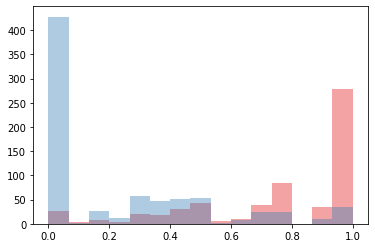

In [13]:
red, blue = sns.color_palette("Set1", 2)
sns.distplot(test_est_p[test_target == 1], kde=False, bins=15, color=red)
sns.distplot(test_est_p[test_target == 0], kde=False, bins=15,color=blue)
plt.show()

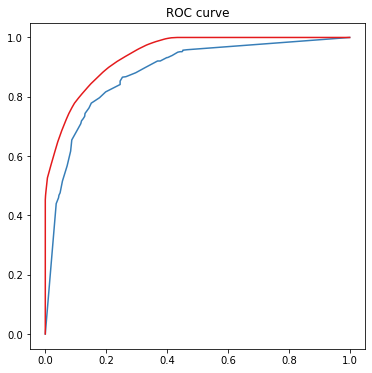

In [14]:
fpr_test, tpr_test, th_test = metrics.roc_curve(test_target, test_est_p)
fpr_train, tpr_train, th_train = metrics.roc_curve(train_target, train_est_p)
plt.figure(figsize=[6,6])
plt.plot(fpr_test, tpr_test, color=blue)
plt.plot(fpr_train, tpr_train, color=red)
plt.title('ROC curve')
plt.show()

### 参数调优

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

param_grid = {
    'criterion':['entropy','gini'],
    'max_depth':[2,3,4,5,6,7,8],
    'min_samples_split':[4,8,12,16,20,24,28] 
}
clf = tree.DecisionTreeClassifier()
clfcv = GridSearchCV(estimator=clf, param_grid=param_grid, 
                   scoring='roc_auc', cv=4)
clfcv.fit(train_data, train_target)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8],
                

### 查看模型预测结果

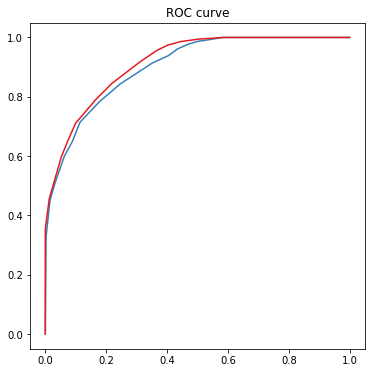

In [16]:
train_est = clfcv.predict(train_data)  #  用模型预测训练集的结果
train_est_p=clfcv.predict_proba(train_data)[:,1]  #用模型预测训练集的概率
test_est=clfcv.predict(test_data)  #  用模型预测测试集的结果
test_est_p=clfcv.predict_proba(test_data)[:,1]  #  用模型预测测试集的概率
#%%
fpr_test, tpr_test, th_test = metrics.roc_curve(test_target, test_est_p)
fpr_train, tpr_train, th_train = metrics.roc_curve(train_target, train_est_p)
plt.figure(figsize=[6,6])
plt.plot(fpr_test, tpr_test, color=blue)
plt.plot(fpr_train, tpr_train, color=red)
plt.title('ROC curve')
plt.show()

In [17]:
clfcv.best_params_

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 24}

In [18]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=24) # 当前支持计算信息增益和GINI
clf.fit(train_data, train_target)  #  使用训练数据建模

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=24,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')